# Advanced Vehicle Loan Default Prediction

In this notebook, we employ advanced techniques to break through the performance ceiling:
1.  **CatBoost & LightGBM**: State-of-the-art gradient boosting models that often outperform XGBoost.
2.  **Threshold Optimization**: Default classification thresholds (0.5) are suboptimal for imbalanced data. We will compute the threshold that maximizes the **F1-Score**.
3.  **Permutation Feature Importance**: rigorous feature selection to remove noise.
4.  **SHAP Analysis**: Experiment explainability.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    f1_score, precision_recall_curve, auc, average_precision_score
)
from sklearn.inspection import permutation_importance

# Install these if missing: pip install catboost lightgbm shap
try:
    from catboost import CatBoostClassifier, Pool
    import lightgbm as lgb
    import shap
except ImportError:
    print("⚠️ Please install missing libraries: pip install catboost lightgbm shap")

# Statsmodels for VIF
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
except ImportError:
    print("⚠️ Please install statsmodels: pip install statsmodels")

warnings.filterwarnings('ignore')

## 1. Data Preparation (Consistent with Previous Best)

In [65]:
# Load data
try:
    df = pd.read_csv('../data/train.csv')
    print(f'Data loaded: {df.shape}')
except FileNotFoundError:
    print("Error: '../data/train.csv' not found.")
    # Stop execution if data not found
    raise

Data loaded: (233154, 41)


In [66]:
# --- PREPROCESSING (Condensed) ---

# 1. Cleaning
cols_to_drop = ['UniqueID', 'Sr. NO', 'MobileNo_Avl_Flag', 'Employee_code_ID', 'Current_pincode_ID']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Target Encoding Functions
def apply_smoothed_encoding(df, target_col, id_cols, m=15):
    global_mean = df[target_col].mean()
    for col in id_cols:
        agg = df.groupby(col)[target_col].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        smooth_val = (counts * means + m * global_mean) / (counts + m)
        df[f'{col}_risk_score'] = df[col].map(smooth_val)
        df.drop(columns=[col], inplace=True)
    return df

ids_to_encode = ['branch_id', 'supplier_id', 'manufacturer_id', 'State_ID']
df = apply_smoothed_encoding(df, 'loan_default', ids_to_encode)

# 3. Derived Features
df['down_payment'] = df['asset_cost'] - df['disbursed_amount']
df['total_monthly_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
df['installment_to_loan_ratio'] = df['total_monthly_installment'] / (df['disbursed_amount'] + 1)

# 4. Dates
def convert_to_months(duration_str):
    import re
    if pd.isna(duration_str) or duration_str == "": return 0
    years = re.findall(r'(\d+)yrs', duration_str)
    months = re.findall(r'(\d+)mon', duration_str)
    total = 0
    if years: total += int(years[0]) * 12
    if months: total += int(months[0])
    return total

df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], dayfirst=True)
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], dayfirst=True)
df['Age_at_Disbursal'] = (df['DisbursalDate'] - df['Date.of.Birth']).dt.days // 365
df['Disbursal_Month'] = df['DisbursalDate'].dt.month
df['Average_Acct_Age_Months'] = df['AVERAGE.ACCT.AGE'].apply(convert_to_months)
df['Credit_History_Length_Months'] = df['CREDIT.HISTORY.LENGTH'].apply(convert_to_months)

df.drop(columns=['Date.of.Birth', 'DisbursalDate', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], inplace=True)

# 5. Bureau scores
def group_bureau_score(desc):
    if desc in ['A-Very Low Risk', 'B-Very Low Risk', 'C-Very Low Risk', 'D-Very Low Risk']:
        return 1 # Very Low
    elif desc in ['E-Low Risk', 'F-Low Risk', 'G-Low Risk']:
        return 2 # Low
    elif desc in ['H-Medium Risk', 'I-Medium Risk']:
        return 3 # Medium
    elif desc in ['J-High Risk', 'K-High Risk']:
        return 4 # High
    elif desc in ['L-Very High Risk', 'M-Very High Risk']:
        return 5 # Very High
    else:
        return 0 # No History

df['Bureau_Score_Category_Encoded'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].apply(group_bureau_score)

# 6. Aggregations (Bureau)
df['Total_No_of_Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df['Total_Active_Accounts'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']
df['Total_Overdue_Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df['Total_Current_Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']

# Log transforms
for col in ['disbursed_amount', 'asset_cost', 'down_payment', 'total_monthly_installment', 'Total_Current_Balance']:
    df[f'log_{col}'] = np.log1p(df[col])
    df[f'log_{col}'] = df[f'log_{col}'].replace([np.inf, -np.inf], 0).fillna(0)

# Drop Redundant
cols_to_drop_final = [
    'disbursed_amount', 'asset_cost', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 
    'PRI.NO.OF.ACCTS', 'SEC.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'SEC.ACTIVE.ACCTS', 
    'PRI.OVERDUE.ACCTS', 'SEC.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'SEC.CURRENT.BALANCE', 
    'PRI.SANCTIONED.AMOUNT', 'SEC.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
    'PERFORM_CNS.SCORE.DESCRIPTION', 'Total_Current_Balance', 'Employment.Type'
]
df.drop(columns=cols_to_drop_final, inplace=True, errors='ignore')

# Final features selection (Reuse the best set)
features_to_keep = [
    'branch_id_risk_score', 'supplier_id_risk_score', 'ltv', 
    'Credit_History_Length_Months', 'Total_Active_Accounts', 
    'Average_Acct_Age_Months', 'log_Total_Current_Balance', 
    'Bureau_Score_Category_Encoded', 'PERFORM_CNS.SCORE', 
    'Total_No_of_Accounts', 'log_total_monthly_installment', 
    'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'Total_Overdue_Accounts', 
    'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
    'NO.OF_INQUIRIES', 'Age_at_Disbursal', 'installment_to_loan_ratio'
]

X = df[features_to_keep]
y = df['loan_default']

## 2. Advanced Training Strategy
- **Train/Test Split**: 80/20 Stratified.
- **Class Weighting**: Instead of SMOTE (which can sometimes introduce noise), we will use the `class_weights` parameter native to CatBoost/LightGBM. This is often more stable for tree boosting.
- **Evaluation**: We look at the PR-Curve and find the optimal F1 threshold.

Class Imbalance Ratio (Neg/Pos): 3.61

--- Checking for Multicollinearity & Removing High VIF Features ---


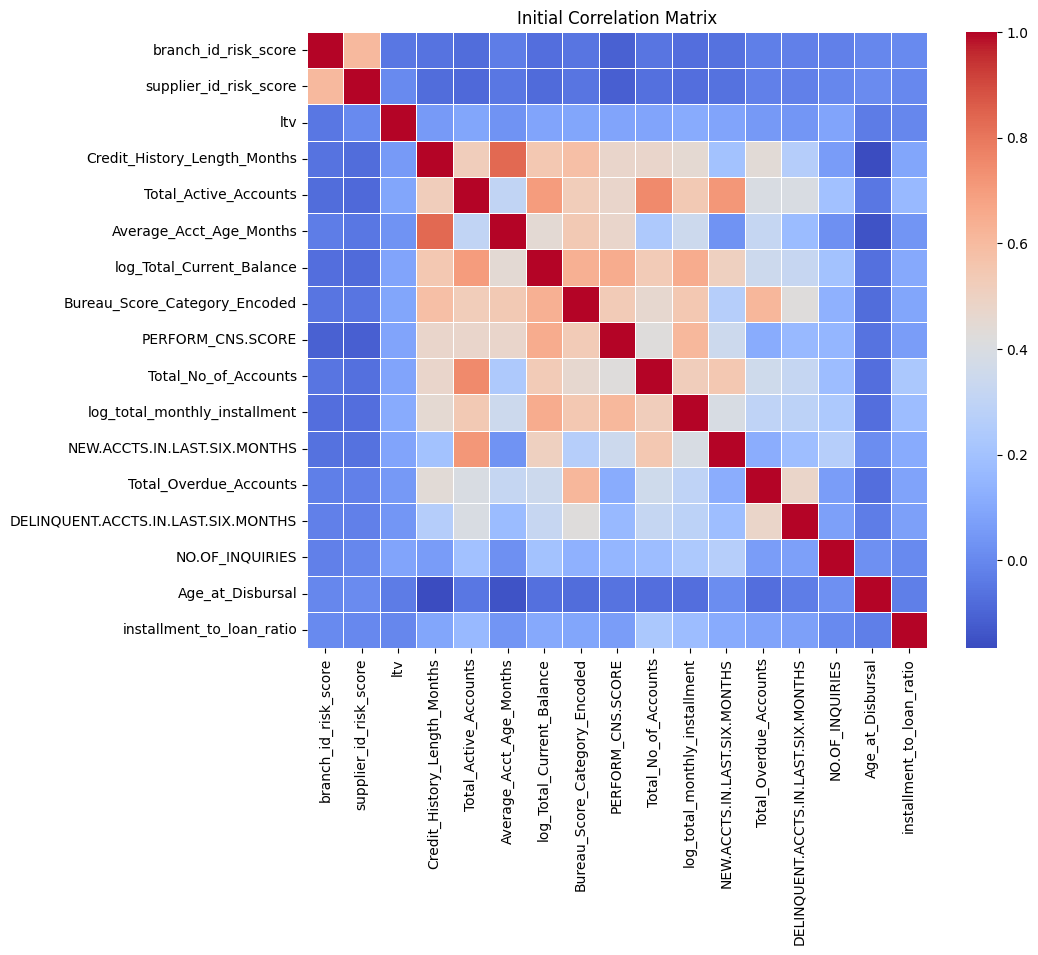

Starting VIF Calculation (Threshold=10)...
All features have VIF <= 10. Max VIF=5.11
Features removed: 0


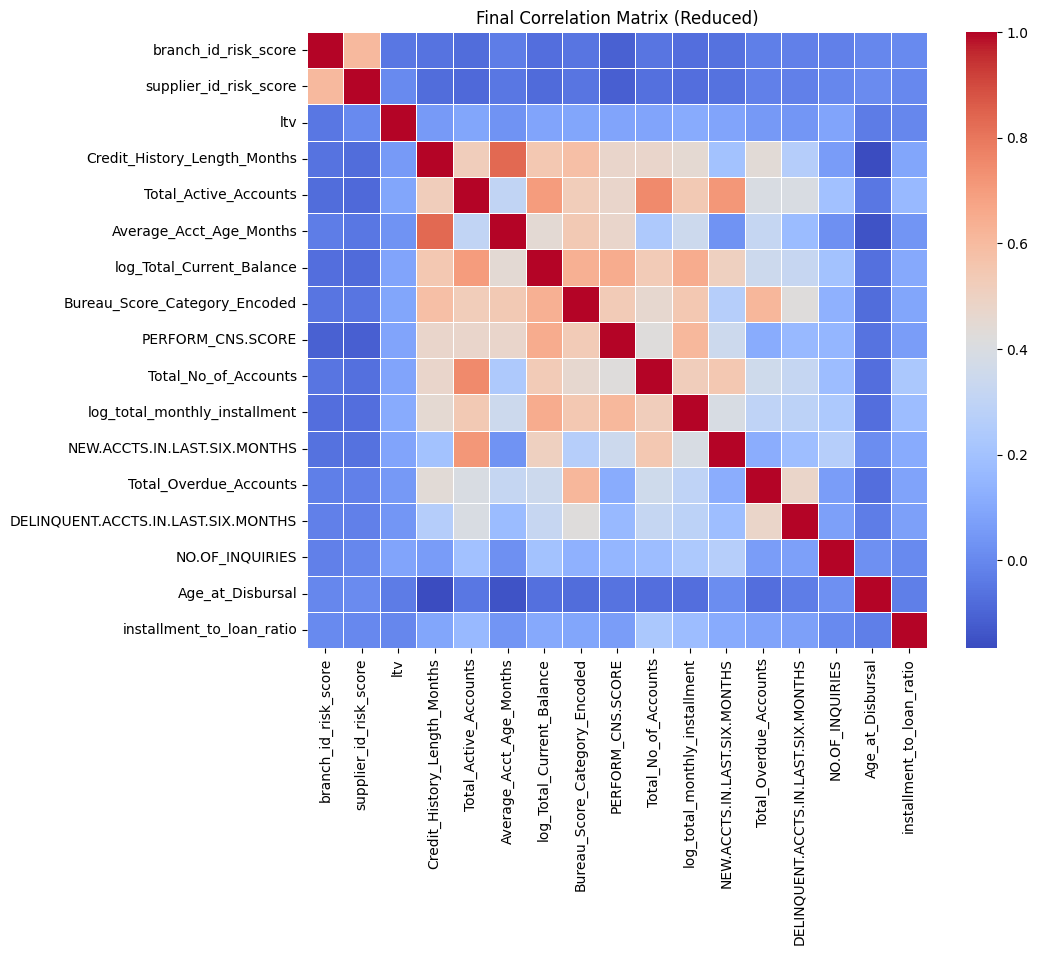

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate Scale Weight for imbalance
scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Class Imbalance Ratio (Neg/Pos): {scale_pos_weight:.2f}")

# --- NEW: Multicollinearity Check & Feature Removal ---
print("\n--- Checking for Multicollinearity & Removing High VIF Features ---")

# 1. Correlation Matrix (Initial)
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Initial Correlation Matrix')
plt.show()

# 2. Iterative VIF Removal
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    # Use a sample for speed if dataset is too large (>50k)
    calc_data = X_train.sample(50000, random_state=42) if len(X_train) > 50000 else X_train
    
    print(f"Starting VIF Calculation (Threshold=10)...")
    
    reduced_features = list(X_train.columns)
    while True:
        # subset data
        X_subset = calc_data[reduced_features]
        X_const = add_constant(X_subset)
        
        # Calculate VIF
        vif_series = pd.Series(
            [variance_inflation_factor(X_const.values, i+1) for i in range(len(X_subset.columns))],
            index=X_subset.columns
        )
        
        max_vif = vif_series.max()
        if max_vif > 10:
            feature_to_drop = vif_series.idxmax()
            print(f"  Dropping '{feature_to_drop}' (VIF={max_vif:.2f})")
            reduced_features.remove(feature_to_drop)
        else:
            print(f"All features have VIF <= 10. Max VIF={max_vif:.2f}")
            break
            
    # Update X_train and X_test
    print(f"Features removed: {len(X_train.columns) - len(reduced_features)}")
    X_train = X_train[reduced_features]
    X_test = X_test[reduced_features] # Sync test set
    
except Exception as e:
    print(f"VIF Removal skipped due to error: {e}")

# 3. Final Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Final Correlation Matrix (Reduced)')
plt.show()

### 3.1 CatBoost Classifier
CatBoost is excellent for categorical data (though we pre-encoded here, it's still robust) and typically requires less tuning.

In [68]:
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    scale_pos_weight=scale_pos_weight,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    early_stopping_rounds=50
)

cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_prob_cat = cat_model.predict_proba(X_test)[:, 1]
print(f"CatBoost ROC-AUC: {roc_auc_score(y_test, y_prob_cat):.4f}")

0:	test: 0.6436322	best: 0.6436322 (0)	total: 23.8ms	remaining: 23.7s
100:	test: 0.6736914	best: 0.6736914 (100)	total: 2.48s	remaining: 22s
200:	test: 0.6758237	best: 0.6758237 (200)	total: 4.96s	remaining: 19.7s
300:	test: 0.6767689	best: 0.6767689 (300)	total: 7.42s	remaining: 17.2s
400:	test: 0.6771956	best: 0.6772092 (399)	total: 9.87s	remaining: 14.7s
500:	test: 0.6773920	best: 0.6775107 (456)	total: 12.7s	remaining: 12.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.677510727
bestIteration = 456

Shrink model to first 457 iterations.
CatBoost ROC-AUC: 0.6775


### 3.2 LightGBM Classifier
LightGBM builds trees leaf-wise (best-first), which can lead to higher accuracy but potential overfitting (handled by params).

In [69]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# NOTE: In LightGBM 4.x, early_stopping_rounds should be passed as a callback or in constructor.
# We use callbacks here for compatibility.
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    eval_metric='auc', 
    callbacks=callbacks
)

y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
print(f"LightGBM ROC-AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")

[LightGBM] [Info] Number of positive: 40489, number of negative: 146034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2270
[LightGBM] [Info] Number of data points in the train set: 186523, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217072 -> initscore=-1.282809
[LightGBM] [Info] Start training from score -1.282809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.657172	valid_0's binary_logloss: 0.518221
LightGBM ROC-AUC: 0.6572


## 4. Threshold Optimization Strategy
Instead of `0.5`, we find the threshold that maximizes `F1-Score`.

--- Optimizing CatBoost Threshold ---
Best Threshold: 0.4835
Max F1-Score: 0.4239

--- Optimized Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.57      0.69     36509
           1       0.31      0.69      0.42     10122

    accuracy                           0.59     46631
   macro avg       0.59      0.63      0.56     46631
weighted avg       0.75      0.59      0.63     46631



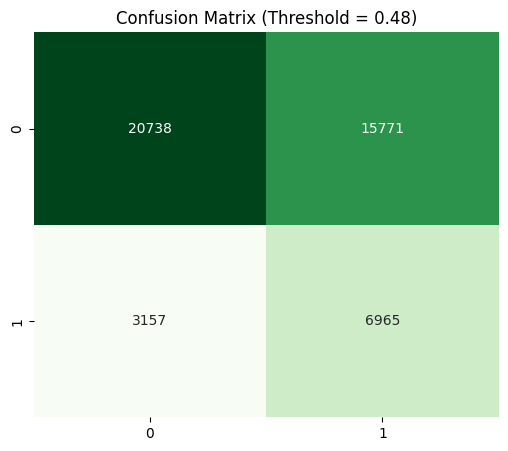

In [70]:
def optimal_threshold_search(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"Best Threshold: {best_thresh:.4f}")
    print(f"Max F1-Score: {best_f1:.4f}")
    
    return best_thresh

print("--- Optimizing CatBoost Threshold ---")
best_thresh_cat = optimal_threshold_search(y_test, y_prob_cat)

y_pred_opt = (y_prob_cat >= best_thresh_cat).astype(int)

print("\n--- Optimized Classification Report ---")
print(classification_report(y_test, y_pred_opt))

# Comparative Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {best_thresh_cat:.2f})')
plt.show()

## 5. Permutation Feature Importance
Verify which features really matter. Randomly shuffling a column and checking performance drop is more robust than split-gain importance.

Calculating Permutation Importance (may take a minute)...


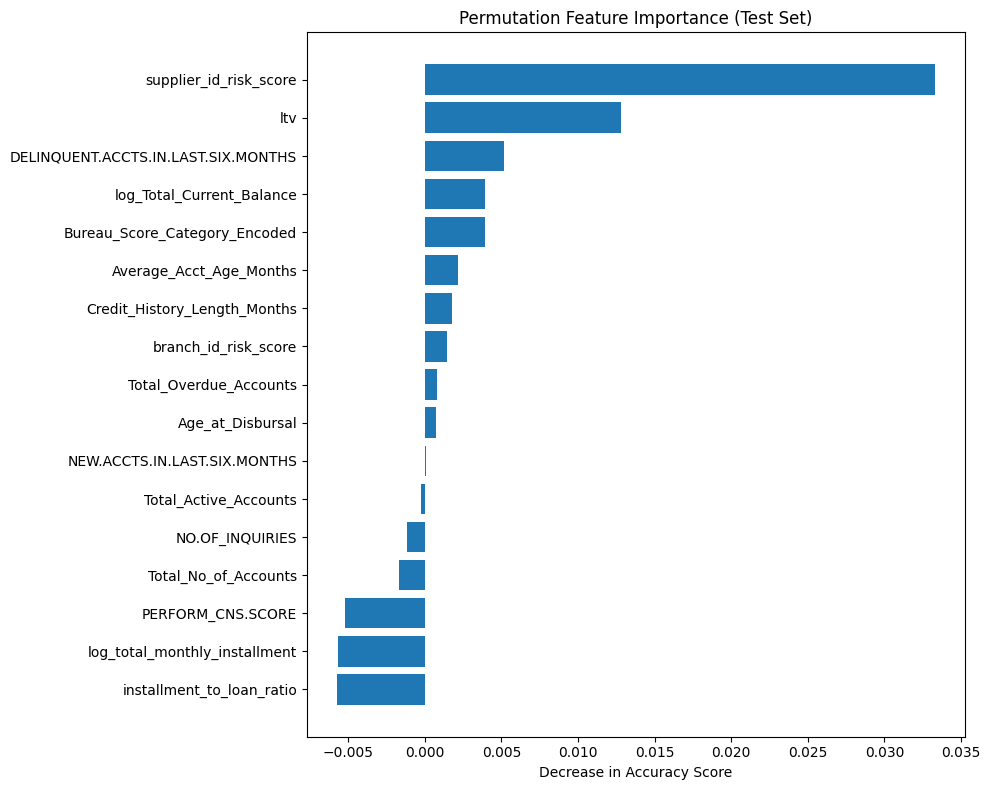

In [71]:
print("Calculating Permutation Importance (may take a minute)...")
# We use a smaller subset of test data for speed if needed, but here we use full X_test
perm_importance = permutation_importance(cat_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Decrease in Accuracy Score")
plt.tight_layout()
plt.show()

## 6. SHAP Analysis
Why are these loans defaulting? Visualizing the "why" behind the predictions.

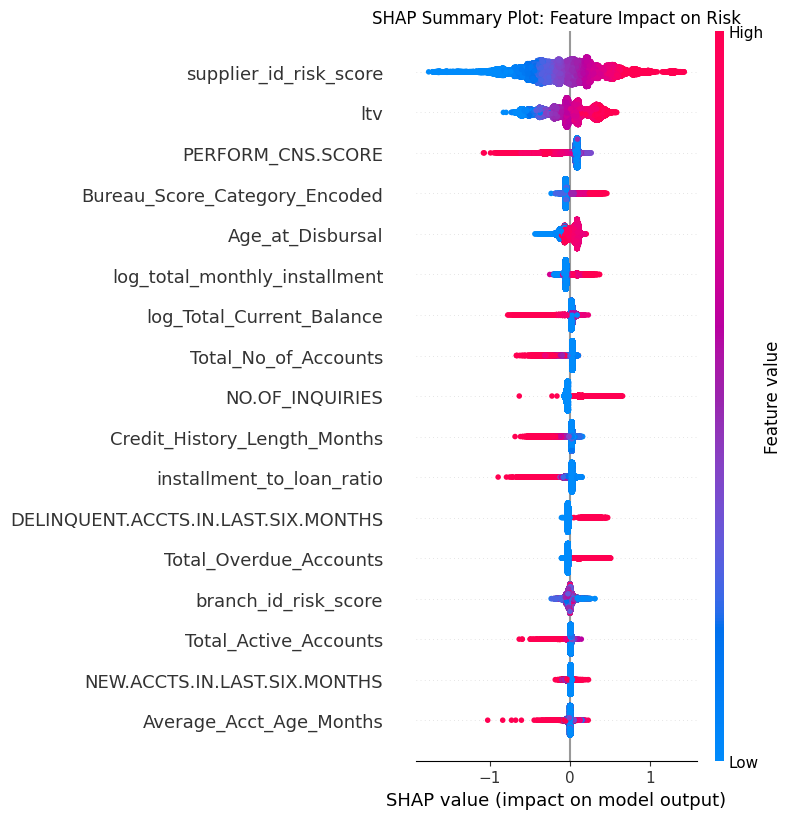

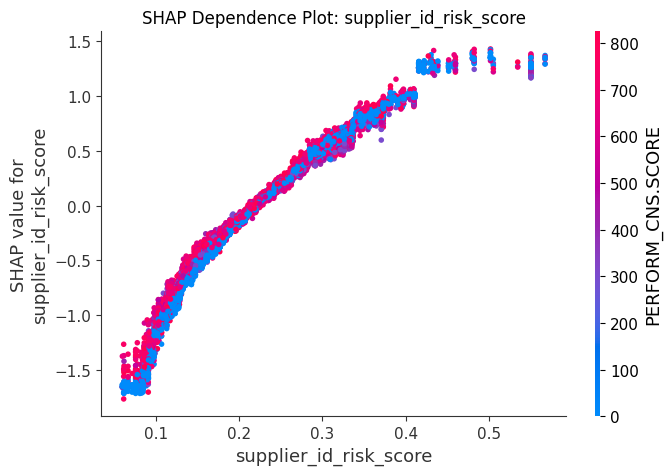

In [73]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot: Feature Impact on Risk")
plt.tight_layout()
plt.show()

# Dependence Plot for Top Feature
# Change 'ltv' to whatever is the top feature in your Importance plot
top_feature = 'supplier_id_risk_score'
shap.dependence_plot(top_feature, shap_values, X_test, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}")
plt.show()